In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import qiskit
from qiskit import QuantumCircuit, Aer, transpile, IBMQ, execute, schedule
from qiskit.test.mock.backends.toronto.fake_toronto import FakeToronto
from qiskit.test.mock.backends.rome.fake_rome import FakeRome

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-sherbrooke')

In [3]:
qasm_sim = provider.get_backend('ibmq_qasm_simulator')
sydney = provider.get_backend('ibmq_sydney')

In [4]:
syd_conf = sydney.configuration()
syd_prop = sydney.properties()

In [5]:
# Find highest single-qubit gate error rate
highest = 0
qubit = None
for q in range(syd_conf.num_qubits):
    current = syd_prop.gate_error('sx', q)
    if highest < current:
        qubit = q
        highest = current
print(f'Highest single-qubit gate error rate: qubit {qubit}')

Highest single-qubit gate error rate: qubit 12


## One quibit circuit

In [9]:
def x_measure():
    qc = QuantumCircuit(1)
    qc.h(0)
    qc.measure_all()
    qc.h(0)
    return qc
xmeas = x_measure()
xmeas_native = transpile(xmeas, sydney, initial_layout=[qubit])
xmeas_sched = schedule(xmeas_native, sydney)
print(f'Duration of the mid-circuit X-measurement: {xmeas_sched.duration}')

Duration of the mid-circuit X-measurement: 24400


In [11]:
slots = 10
circuits = []

qc = QuantumCircuit(1,1)
qc.h(0)

for i in range(slots):
    qc = QuantumCircuit(1,1)
    qc.h(0)
    qc = transpile(qc, sydney, initial_layout=[qubit])
    
    for _ in range(i):
        qc = qc.compose(xmeas_native)
    qc.delay((slots-i-1) * xmeas_sched.duration, qarg=qubit)
    qc.measure(qubit,0)
    circuits.append(qc)

In [39]:
# Run the same circuits 30 times in order to have statistical average
job = execute(circuits*30, qasm_sim, backend_properties=syd_prop, optimization_level=0, shots=4096) #, initial_layout=[qubit]
job.job_id()

'605b7a6811fac48b97943b63'

In [56]:
res = provider.backends.retrieve_job('605b7a6811fac48b97943b63').result()

sim_ratio = [c['1']/c['0'] for c in res.get_counts()]
sim_df = pd.DataFrame(columns=['number_meas', 'ratio'])
for i in range(len(sim_ratio)):
    entry = {'number_meas': i%10, 'ratio': sim_ratio[i]}
    sim_df = sim_df.append(entry, ignore_index=True)
sim_df = sim_df.astype({'number_meas': int})

In [19]:
job = execute(circuits, sydney, shots=4096, optimization_level=0)
job.job_id()

'605b5dd46b0b890f14adb373'

In [58]:
res = provider.backends.retrieve_job('605b5dd46b0b890f14adb373').result()

syd_ratio = [c['1']/c['0'] for c in res.get_counts()]

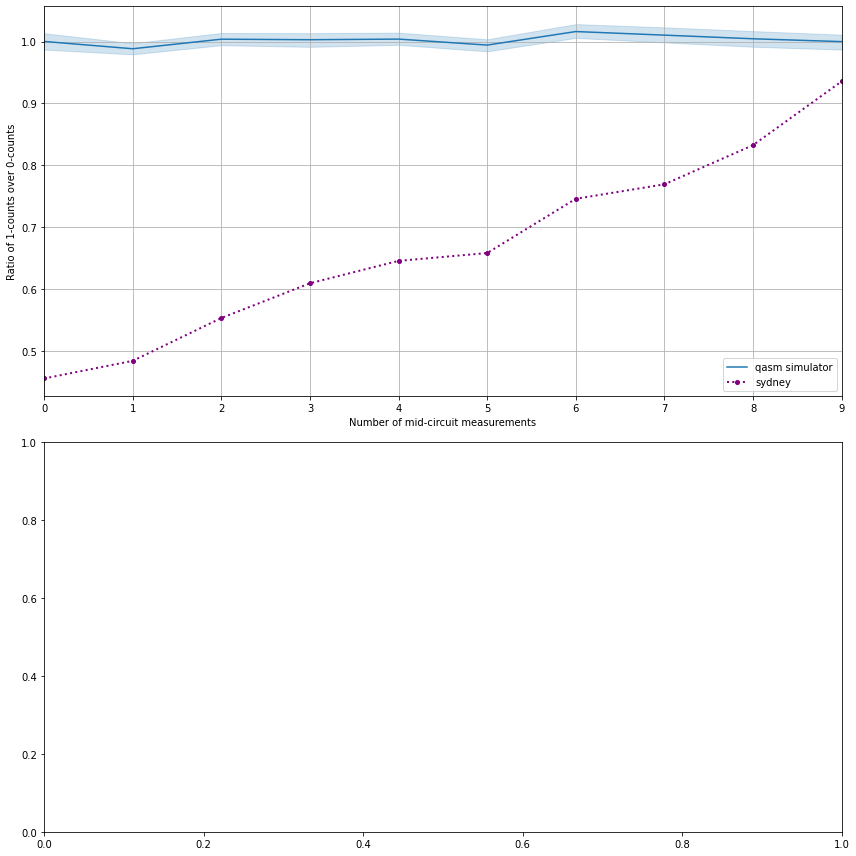

In [66]:
fig, axs = plt.subplots(2, figsize=(12,12))

sns.lineplot(ax=axs[0], x="number_meas", y="ratio", data=sim_df, label='qasm simulator')

axs[0].plot(list(range(slots)), syd_ratio, label='sydney', color='purple', marker='o', linestyle='dotted', linewidth=2, markersize=4)
axs[0].grid(True)
axs[0].legend()
axs[0].set_xlabel('Number of mid-circuit measurements')
axs[0].set_ylabel('Ratio of 1-counts over 0-counts')
axs[0].set_xlim(0, 9)

#text = f'Circuit duration: {xmeas_sched.duration} ??s'
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.2)
#axs[0].text(0.9, 0.9, text, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)

fig.tight_layout()
plt.show()